# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

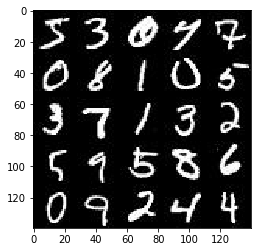

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [3]:
print('Image shape: ', mnist_images[0].shape)
print('Image max value: ', mnist_images.max())
print('Image min value: ', mnist_images.min())

Image shape:  (28, 28, 1)
Image max value:  255.0
Image min value:  0.0


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

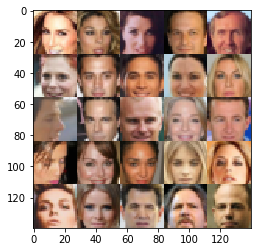

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

In [5]:
print('Image shape: ', celeba_images[0].shape)
print('Image max value: ', celeba_images.max())
print('Image min value: ', celeba_images.min())

Image shape:  (28, 28, 3)
Image max value:  255.0
Image min value:  0.0


## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

C:\ProgramData\Anaconda2\envs\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2  # negative slope coefficient for the leaky ReLu activation function
    keep_prob = 0.9  # keep probability for the dropout layer
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # each input size: width * height * channel
        x1 = tf.layers.conv2d(images, 64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        # each input size: (width/2) * (height/2) * 64
        x2 = tf.layers.conv2d(x1, 128, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        # each input size: (width/4) * (height/4) * 128
        x3 = tf.layers.conv2d(x2, 256, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        # each input size: (width/8) * (height/8) * 256
        flat = tf.layers.flatten(x3)
        
        d_logit = tf.layers.dense(flat, 1, activation=None)
        d_out = tf.sigmoid(d_logit)
        
    return d_out, d_logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0  # negative slope coefficient for the leaky ReLu activation function, 0 for ReLU (tf.nn.relu)
    keep_prob = 0.9  # keep probability for the dropout layer
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        x1 = tf.layers.dense(z, 7*7*512, activation=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # each input size: 7 * 7 * 512
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        # each input size: 14 * 14 * 256
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        # each input size: 28 * 28 * 128
        g_out = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size=(3, 3), strides=(1, 1), padding='same',
                                           activation=tf.tanh)
        
    return g_out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logit_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logit_fake = discriminator(g_out, reuse=True)
    
    label_smooth = 0.1  # label smoothing factor for GAN
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logit_real,
            labels=(1 - label_smooth) * tf.ones_like(d_out_real)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logit_fake,
            labels=label_smooth * tf.ones_like(d_out_real)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logit_fake,
            labels=tf.ones_like(d_out_fake)
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # get trainable variables
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width, image_height, image_channels = data_shape[1:]
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    print_every = 10
    show_every = 100
    n_images = 16
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_i += 1
                
                batch_images *= 2  # input batch_images range: [-0.5, 0.5], needs to be [-1, 1] for tanh
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                # display losses
                if batch_i % print_every == 0:
                    d_loss_train = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    g_loss_train = g_loss.eval(feed_dict={input_z: batch_z})
                    print('Epoch {}/{}, Batch {}...'.format(epoch_i+1, epoch_count, batch_i),
                          'Discriminator Loss: {:.4f}...'.format(d_loss_train),
                          'Generator Loss: {:.4f}'.format(g_loss_train))
            
                # print generated images
                if batch_i % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
            
            # print generated images after every epoch
            show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, Batch 10... Discriminator Loss: 0.7322... Generator Loss: 2.2942
Epoch 1/2, Batch 20... Discriminator Loss: 1.5139... Generator Loss: 7.3363
Epoch 1/2, Batch 30... Discriminator Loss: 1.0989... Generator Loss: 1.0565
Epoch 1/2, Batch 40... Discriminator Loss: 2.5841... Generator Loss: 0.1494
Epoch 1/2, Batch 50... Discriminator Loss: 0.9629... Generator Loss: 1.6055
Epoch 1/2, Batch 60... Discriminator Loss: 1.0159... Generator Loss: 1.8320
Epoch 1/2, Batch 70... Discriminator Loss: 1.1397... Generator Loss: 1.2729
Epoch 1/2, Batch 80... Discriminator Loss: 1.1494... Generator Loss: 0.8842
Epoch 1/2, Batch 90... Discriminator Loss: 1.2333... Generator Loss: 1.3384
Epoch 1/2, Batch 100... Discriminator Loss: 1.3150... Generator Loss: 0.9664


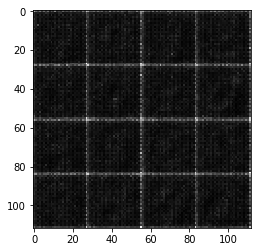

Epoch 1/2, Batch 110... Discriminator Loss: 1.5097... Generator Loss: 0.5432
Epoch 1/2, Batch 120... Discriminator Loss: 1.3493... Generator Loss: 0.6676
Epoch 1/2, Batch 130... Discriminator Loss: 1.4439... Generator Loss: 0.5738
Epoch 1/2, Batch 140... Discriminator Loss: 1.4743... Generator Loss: 0.7157
Epoch 1/2, Batch 150... Discriminator Loss: 1.4626... Generator Loss: 0.5421
Epoch 1/2, Batch 160... Discriminator Loss: 1.3401... Generator Loss: 0.8895
Epoch 1/2, Batch 170... Discriminator Loss: 1.1880... Generator Loss: 1.3523
Epoch 1/2, Batch 180... Discriminator Loss: 1.2264... Generator Loss: 1.0780
Epoch 1/2, Batch 190... Discriminator Loss: 1.2677... Generator Loss: 0.6852
Epoch 1/2, Batch 200... Discriminator Loss: 1.2217... Generator Loss: 0.6981


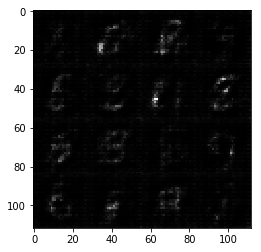

Epoch 1/2, Batch 210... Discriminator Loss: 1.1627... Generator Loss: 1.2509
Epoch 1/2, Batch 220... Discriminator Loss: 1.2820... Generator Loss: 0.9170
Epoch 1/2, Batch 230... Discriminator Loss: 1.3662... Generator Loss: 0.5997
Epoch 1/2, Batch 240... Discriminator Loss: 1.2429... Generator Loss: 0.8019
Epoch 1/2, Batch 250... Discriminator Loss: 1.0743... Generator Loss: 1.1271
Epoch 1/2, Batch 260... Discriminator Loss: 1.1624... Generator Loss: 0.8086
Epoch 1/2, Batch 270... Discriminator Loss: 1.0764... Generator Loss: 1.1970
Epoch 1/2, Batch 280... Discriminator Loss: 1.2168... Generator Loss: 0.7626
Epoch 1/2, Batch 290... Discriminator Loss: 1.2673... Generator Loss: 0.6443
Epoch 1/2, Batch 300... Discriminator Loss: 1.1257... Generator Loss: 1.0466


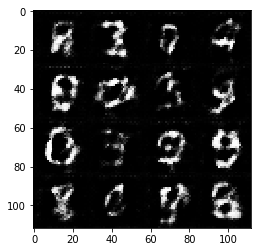

Epoch 1/2, Batch 310... Discriminator Loss: 1.0678... Generator Loss: 1.0852
Epoch 1/2, Batch 320... Discriminator Loss: 1.3114... Generator Loss: 1.3494
Epoch 1/2, Batch 330... Discriminator Loss: 1.0457... Generator Loss: 1.2354
Epoch 1/2, Batch 340... Discriminator Loss: 1.0833... Generator Loss: 0.8720
Epoch 1/2, Batch 350... Discriminator Loss: 1.1220... Generator Loss: 1.7049
Epoch 1/2, Batch 360... Discriminator Loss: 1.1067... Generator Loss: 0.8090
Epoch 1/2, Batch 370... Discriminator Loss: 1.1690... Generator Loss: 0.8425
Epoch 1/2, Batch 380... Discriminator Loss: 1.0721... Generator Loss: 0.8793
Epoch 1/2, Batch 390... Discriminator Loss: 1.1874... Generator Loss: 1.0930
Epoch 1/2, Batch 400... Discriminator Loss: 1.2665... Generator Loss: 0.7018


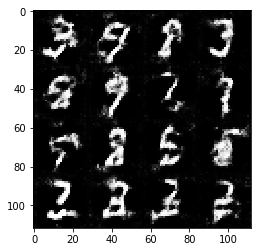

Epoch 1/2, Batch 410... Discriminator Loss: 1.3023... Generator Loss: 0.6191
Epoch 1/2, Batch 420... Discriminator Loss: 1.2094... Generator Loss: 1.4784
Epoch 1/2, Batch 430... Discriminator Loss: 1.1912... Generator Loss: 1.1218
Epoch 1/2, Batch 440... Discriminator Loss: 1.2171... Generator Loss: 1.1547
Epoch 1/2, Batch 450... Discriminator Loss: 1.1642... Generator Loss: 1.0111
Epoch 1/2, Batch 460... Discriminator Loss: 1.2404... Generator Loss: 0.6950
Epoch 1/2, Batch 470... Discriminator Loss: 1.1981... Generator Loss: 0.7496
Epoch 1/2, Batch 480... Discriminator Loss: 1.2502... Generator Loss: 0.6143
Epoch 1/2, Batch 490... Discriminator Loss: 1.2992... Generator Loss: 0.6449
Epoch 1/2, Batch 500... Discriminator Loss: 1.1156... Generator Loss: 0.9028


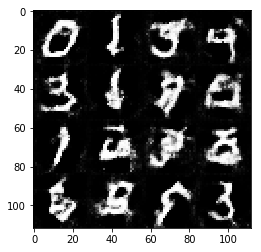

Epoch 1/2, Batch 510... Discriminator Loss: 1.2583... Generator Loss: 0.9179
Epoch 1/2, Batch 520... Discriminator Loss: 1.2254... Generator Loss: 0.7920
Epoch 1/2, Batch 530... Discriminator Loss: 1.1419... Generator Loss: 0.8616
Epoch 1/2, Batch 540... Discriminator Loss: 1.1757... Generator Loss: 1.0031
Epoch 1/2, Batch 550... Discriminator Loss: 1.2425... Generator Loss: 0.8130
Epoch 1/2, Batch 560... Discriminator Loss: 1.3584... Generator Loss: 0.5436
Epoch 1/2, Batch 570... Discriminator Loss: 1.6616... Generator Loss: 0.3581
Epoch 1/2, Batch 580... Discriminator Loss: 1.4600... Generator Loss: 0.4965
Epoch 1/2, Batch 590... Discriminator Loss: 1.1739... Generator Loss: 0.7491
Epoch 1/2, Batch 600... Discriminator Loss: 1.2320... Generator Loss: 0.7589


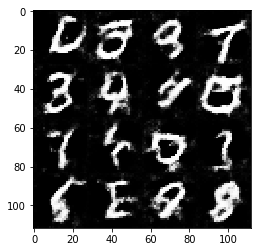

Epoch 1/2, Batch 610... Discriminator Loss: 1.2298... Generator Loss: 1.2014
Epoch 1/2, Batch 620... Discriminator Loss: 1.1751... Generator Loss: 0.9626
Epoch 1/2, Batch 630... Discriminator Loss: 1.1995... Generator Loss: 0.6773
Epoch 1/2, Batch 640... Discriminator Loss: 1.2026... Generator Loss: 0.9926
Epoch 1/2, Batch 650... Discriminator Loss: 1.3083... Generator Loss: 0.9474
Epoch 1/2, Batch 660... Discriminator Loss: 1.2627... Generator Loss: 0.9819
Epoch 1/2, Batch 670... Discriminator Loss: 1.2735... Generator Loss: 1.2115
Epoch 1/2, Batch 680... Discriminator Loss: 1.3205... Generator Loss: 0.7721
Epoch 1/2, Batch 690... Discriminator Loss: 1.3626... Generator Loss: 0.5075
Epoch 1/2, Batch 700... Discriminator Loss: 1.2118... Generator Loss: 0.8636


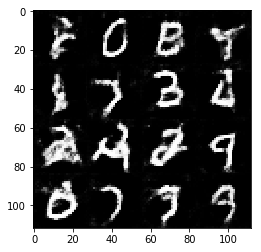

Epoch 1/2, Batch 710... Discriminator Loss: 1.2795... Generator Loss: 0.7021
Epoch 1/2, Batch 720... Discriminator Loss: 1.2584... Generator Loss: 0.6488
Epoch 1/2, Batch 730... Discriminator Loss: 1.2081... Generator Loss: 0.7546
Epoch 1/2, Batch 740... Discriminator Loss: 1.1441... Generator Loss: 0.8636
Epoch 1/2, Batch 750... Discriminator Loss: 1.1920... Generator Loss: 1.1049
Epoch 1/2, Batch 760... Discriminator Loss: 1.1909... Generator Loss: 0.7055
Epoch 1/2, Batch 770... Discriminator Loss: 1.2763... Generator Loss: 0.6900
Epoch 1/2, Batch 780... Discriminator Loss: 1.2392... Generator Loss: 0.8913
Epoch 1/2, Batch 790... Discriminator Loss: 1.2421... Generator Loss: 1.0400
Epoch 1/2, Batch 800... Discriminator Loss: 1.2537... Generator Loss: 0.7381


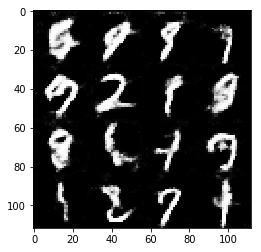

Epoch 1/2, Batch 810... Discriminator Loss: 1.2094... Generator Loss: 1.2191
Epoch 1/2, Batch 820... Discriminator Loss: 1.2387... Generator Loss: 0.7455
Epoch 1/2, Batch 830... Discriminator Loss: 1.2902... Generator Loss: 1.3024
Epoch 1/2, Batch 840... Discriminator Loss: 1.0375... Generator Loss: 0.9910
Epoch 1/2, Batch 850... Discriminator Loss: 1.0851... Generator Loss: 1.1524
Epoch 1/2, Batch 860... Discriminator Loss: 1.5864... Generator Loss: 0.5126
Epoch 1/2, Batch 870... Discriminator Loss: 1.3389... Generator Loss: 0.9822
Epoch 1/2, Batch 880... Discriminator Loss: 1.1648... Generator Loss: 0.8092
Epoch 1/2, Batch 890... Discriminator Loss: 1.1137... Generator Loss: 0.9717
Epoch 1/2, Batch 900... Discriminator Loss: 1.1964... Generator Loss: 1.0049


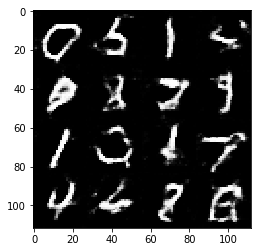

Epoch 1/2, Batch 910... Discriminator Loss: 1.2721... Generator Loss: 0.7684
Epoch 1/2, Batch 920... Discriminator Loss: 1.1121... Generator Loss: 1.0934
Epoch 1/2, Batch 930... Discriminator Loss: 1.2319... Generator Loss: 0.8298


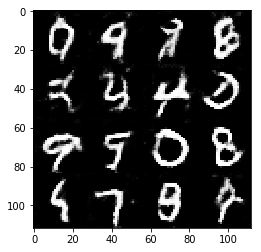

Epoch 2/2, Batch 10... Discriminator Loss: 1.2363... Generator Loss: 0.7413
Epoch 2/2, Batch 20... Discriminator Loss: 1.2791... Generator Loss: 0.7512
Epoch 2/2, Batch 30... Discriminator Loss: 1.1898... Generator Loss: 0.9467
Epoch 2/2, Batch 40... Discriminator Loss: 1.2364... Generator Loss: 0.7159
Epoch 2/2, Batch 50... Discriminator Loss: 1.2588... Generator Loss: 0.9753
Epoch 2/2, Batch 60... Discriminator Loss: 1.2284... Generator Loss: 0.7549
Epoch 2/2, Batch 70... Discriminator Loss: 1.1597... Generator Loss: 0.7971
Epoch 2/2, Batch 80... Discriminator Loss: 1.3183... Generator Loss: 0.8285
Epoch 2/2, Batch 90... Discriminator Loss: 1.1971... Generator Loss: 0.6753
Epoch 2/2, Batch 100... Discriminator Loss: 1.2363... Generator Loss: 0.7524


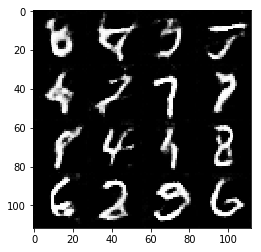

Epoch 2/2, Batch 110... Discriminator Loss: 1.1223... Generator Loss: 0.9128
Epoch 2/2, Batch 120... Discriminator Loss: 1.2838... Generator Loss: 1.5548
Epoch 2/2, Batch 130... Discriminator Loss: 1.2087... Generator Loss: 0.9744
Epoch 2/2, Batch 140... Discriminator Loss: 1.2467... Generator Loss: 0.9254
Epoch 2/2, Batch 150... Discriminator Loss: 1.3278... Generator Loss: 0.6464
Epoch 2/2, Batch 160... Discriminator Loss: 1.2456... Generator Loss: 0.6256
Epoch 2/2, Batch 170... Discriminator Loss: 1.1114... Generator Loss: 0.9407
Epoch 2/2, Batch 180... Discriminator Loss: 1.2051... Generator Loss: 0.8160
Epoch 2/2, Batch 190... Discriminator Loss: 1.1517... Generator Loss: 0.9933
Epoch 2/2, Batch 200... Discriminator Loss: 1.1340... Generator Loss: 0.9419


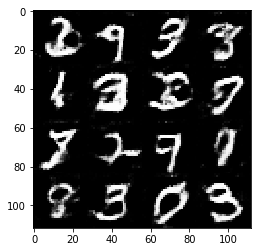

Epoch 2/2, Batch 210... Discriminator Loss: 1.1331... Generator Loss: 0.9149
Epoch 2/2, Batch 220... Discriminator Loss: 1.1806... Generator Loss: 0.9152
Epoch 2/2, Batch 230... Discriminator Loss: 1.1417... Generator Loss: 0.9985
Epoch 2/2, Batch 240... Discriminator Loss: 1.4823... Generator Loss: 0.4703
Epoch 2/2, Batch 250... Discriminator Loss: 1.0627... Generator Loss: 1.1351
Epoch 2/2, Batch 260... Discriminator Loss: 1.0878... Generator Loss: 0.9736
Epoch 2/2, Batch 270... Discriminator Loss: 1.2030... Generator Loss: 0.8127
Epoch 2/2, Batch 280... Discriminator Loss: 1.2579... Generator Loss: 0.9622
Epoch 2/2, Batch 290... Discriminator Loss: 1.1436... Generator Loss: 0.8376
Epoch 2/2, Batch 300... Discriminator Loss: 1.2338... Generator Loss: 0.7178


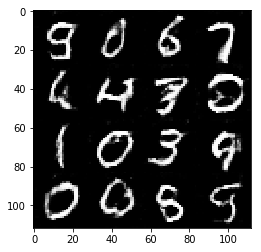

Epoch 2/2, Batch 310... Discriminator Loss: 1.1789... Generator Loss: 1.0577
Epoch 2/2, Batch 320... Discriminator Loss: 1.3476... Generator Loss: 0.4879
Epoch 2/2, Batch 330... Discriminator Loss: 1.1698... Generator Loss: 0.8348
Epoch 2/2, Batch 340... Discriminator Loss: 1.3008... Generator Loss: 0.5442
Epoch 2/2, Batch 350... Discriminator Loss: 1.1381... Generator Loss: 1.4540
Epoch 2/2, Batch 360... Discriminator Loss: 1.1427... Generator Loss: 0.7814
Epoch 2/2, Batch 370... Discriminator Loss: 1.4282... Generator Loss: 0.5033
Epoch 2/2, Batch 380... Discriminator Loss: 1.1081... Generator Loss: 0.9139
Epoch 2/2, Batch 390... Discriminator Loss: 1.1814... Generator Loss: 0.7961
Epoch 2/2, Batch 400... Discriminator Loss: 1.1946... Generator Loss: 0.7945


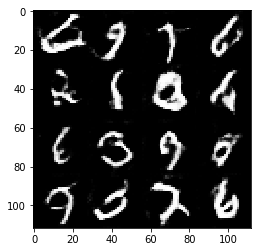

Epoch 2/2, Batch 410... Discriminator Loss: 1.2115... Generator Loss: 1.1636
Epoch 2/2, Batch 420... Discriminator Loss: 1.2161... Generator Loss: 1.1664
Epoch 2/2, Batch 430... Discriminator Loss: 1.2291... Generator Loss: 1.0320
Epoch 2/2, Batch 440... Discriminator Loss: 1.1899... Generator Loss: 0.6974
Epoch 2/2, Batch 450... Discriminator Loss: 1.0541... Generator Loss: 1.2671
Epoch 2/2, Batch 460... Discriminator Loss: 1.2098... Generator Loss: 0.9617
Epoch 2/2, Batch 470... Discriminator Loss: 1.1851... Generator Loss: 0.8202
Epoch 2/2, Batch 480... Discriminator Loss: 1.2122... Generator Loss: 0.8162
Epoch 2/2, Batch 490... Discriminator Loss: 1.2004... Generator Loss: 0.7338
Epoch 2/2, Batch 500... Discriminator Loss: 1.2108... Generator Loss: 0.7018


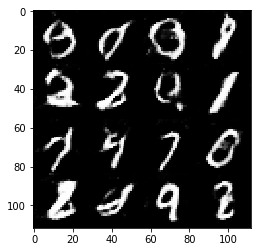

Epoch 2/2, Batch 510... Discriminator Loss: 1.2405... Generator Loss: 1.0345
Epoch 2/2, Batch 520... Discriminator Loss: 1.2259... Generator Loss: 0.6443
Epoch 2/2, Batch 530... Discriminator Loss: 1.4136... Generator Loss: 1.7544
Epoch 2/2, Batch 540... Discriminator Loss: 1.1878... Generator Loss: 0.7802
Epoch 2/2, Batch 550... Discriminator Loss: 1.0843... Generator Loss: 1.0383
Epoch 2/2, Batch 560... Discriminator Loss: 1.1210... Generator Loss: 0.8692
Epoch 2/2, Batch 570... Discriminator Loss: 1.2209... Generator Loss: 0.6785
Epoch 2/2, Batch 580... Discriminator Loss: 1.2140... Generator Loss: 0.8884
Epoch 2/2, Batch 590... Discriminator Loss: 1.1738... Generator Loss: 0.7292
Epoch 2/2, Batch 600... Discriminator Loss: 1.1761... Generator Loss: 0.7526


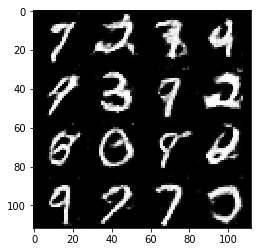

Epoch 2/2, Batch 610... Discriminator Loss: 1.2324... Generator Loss: 0.7135
Epoch 2/2, Batch 620... Discriminator Loss: 1.1561... Generator Loss: 0.8919
Epoch 2/2, Batch 630... Discriminator Loss: 1.1837... Generator Loss: 0.9247
Epoch 2/2, Batch 640... Discriminator Loss: 1.2066... Generator Loss: 0.8013
Epoch 2/2, Batch 650... Discriminator Loss: 1.3490... Generator Loss: 1.3142
Epoch 2/2, Batch 660... Discriminator Loss: 1.2518... Generator Loss: 0.6181
Epoch 2/2, Batch 670... Discriminator Loss: 1.4708... Generator Loss: 1.0745
Epoch 2/2, Batch 680... Discriminator Loss: 1.3993... Generator Loss: 0.7536
Epoch 2/2, Batch 690... Discriminator Loss: 1.1397... Generator Loss: 1.0311
Epoch 2/2, Batch 700... Discriminator Loss: 1.1440... Generator Loss: 0.8396


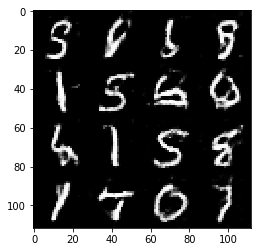

Epoch 2/2, Batch 710... Discriminator Loss: 1.1342... Generator Loss: 0.7876
Epoch 2/2, Batch 720... Discriminator Loss: 1.4157... Generator Loss: 0.4824
Epoch 2/2, Batch 730... Discriminator Loss: 1.1924... Generator Loss: 0.7760
Epoch 2/2, Batch 740... Discriminator Loss: 1.1108... Generator Loss: 0.9774
Epoch 2/2, Batch 750... Discriminator Loss: 1.4465... Generator Loss: 0.4410
Epoch 2/2, Batch 760... Discriminator Loss: 1.1510... Generator Loss: 0.7987
Epoch 2/2, Batch 770... Discriminator Loss: 1.1544... Generator Loss: 1.0480
Epoch 2/2, Batch 780... Discriminator Loss: 1.1773... Generator Loss: 0.7120
Epoch 2/2, Batch 790... Discriminator Loss: 1.3213... Generator Loss: 0.5995
Epoch 2/2, Batch 800... Discriminator Loss: 1.2355... Generator Loss: 0.8274


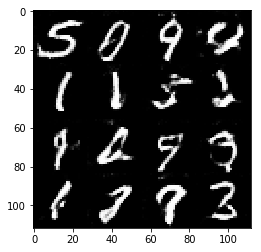

Epoch 2/2, Batch 810... Discriminator Loss: 1.1203... Generator Loss: 0.9622
Epoch 2/2, Batch 820... Discriminator Loss: 1.3170... Generator Loss: 1.5917
Epoch 2/2, Batch 830... Discriminator Loss: 1.1894... Generator Loss: 0.6531
Epoch 2/2, Batch 840... Discriminator Loss: 0.9417... Generator Loss: 1.4741
Epoch 2/2, Batch 850... Discriminator Loss: 1.1635... Generator Loss: 1.5090
Epoch 2/2, Batch 860... Discriminator Loss: 1.5144... Generator Loss: 0.3745
Epoch 2/2, Batch 870... Discriminator Loss: 1.3488... Generator Loss: 0.8135
Epoch 2/2, Batch 880... Discriminator Loss: 1.1849... Generator Loss: 0.6999
Epoch 2/2, Batch 890... Discriminator Loss: 1.1338... Generator Loss: 1.0396
Epoch 2/2, Batch 900... Discriminator Loss: 1.1938... Generator Loss: 0.8883


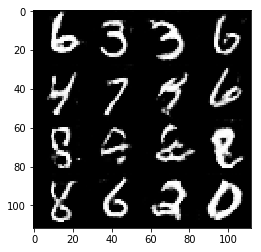

Epoch 2/2, Batch 910... Discriminator Loss: 1.2826... Generator Loss: 0.5802
Epoch 2/2, Batch 920... Discriminator Loss: 1.4241... Generator Loss: 1.2975
Epoch 2/2, Batch 930... Discriminator Loss: 1.2612... Generator Loss: 0.6606


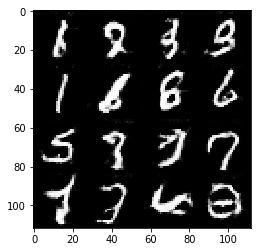

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, Batch 10... Discriminator Loss: 1.3074... Generator Loss: 8.2762
Epoch 1/1, Batch 20... Discriminator Loss: 1.5216... Generator Loss: 10.8295
Epoch 1/1, Batch 30... Discriminator Loss: 0.9251... Generator Loss: 5.4031
Epoch 1/1, Batch 40... Discriminator Loss: 0.9726... Generator Loss: 0.8551
Epoch 1/1, Batch 50... Discriminator Loss: 4.9882... Generator Loss: 0.0093
Epoch 1/1, Batch 60... Discriminator Loss: 1.4942... Generator Loss: 0.5468
Epoch 1/1, Batch 70... Discriminator Loss: 1.4411... Generator Loss: 4.8352
Epoch 1/1, Batch 80... Discriminator Loss: 1.2941... Generator Loss: 1.1797
Epoch 1/1, Batch 90... Discriminator Loss: 1.2210... Generator Loss: 0.6896
Epoch 1/1, Batch 100... Discriminator Loss: 1.2884... Generator Loss: 0.5898


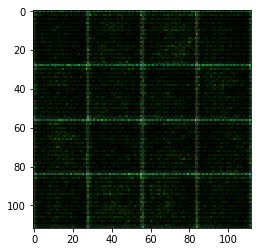

Epoch 1/1, Batch 110... Discriminator Loss: 1.1908... Generator Loss: 0.6481
Epoch 1/1, Batch 120... Discriminator Loss: 0.9609... Generator Loss: 1.9683
Epoch 1/1, Batch 130... Discriminator Loss: 1.0401... Generator Loss: 0.8359
Epoch 1/1, Batch 140... Discriminator Loss: 0.7724... Generator Loss: 1.8674
Epoch 1/1, Batch 150... Discriminator Loss: 0.9116... Generator Loss: 1.1899
Epoch 1/1, Batch 160... Discriminator Loss: 0.9905... Generator Loss: 0.9218
Epoch 1/1, Batch 170... Discriminator Loss: 1.1937... Generator Loss: 0.6722
Epoch 1/1, Batch 180... Discriminator Loss: 1.2298... Generator Loss: 0.6389
Epoch 1/1, Batch 190... Discriminator Loss: 1.0249... Generator Loss: 1.6914
Epoch 1/1, Batch 200... Discriminator Loss: 1.2684... Generator Loss: 0.5886


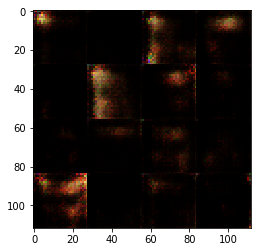

Epoch 1/1, Batch 210... Discriminator Loss: 1.3387... Generator Loss: 0.4559
Epoch 1/1, Batch 220... Discriminator Loss: 1.2403... Generator Loss: 1.2568
Epoch 1/1, Batch 230... Discriminator Loss: 1.1562... Generator Loss: 1.1612
Epoch 1/1, Batch 240... Discriminator Loss: 1.4592... Generator Loss: 0.4490
Epoch 1/1, Batch 250... Discriminator Loss: 1.3001... Generator Loss: 1.5653
Epoch 1/1, Batch 260... Discriminator Loss: 1.6809... Generator Loss: 2.1044
Epoch 1/1, Batch 270... Discriminator Loss: 1.2349... Generator Loss: 0.6440
Epoch 1/1, Batch 280... Discriminator Loss: 1.5027... Generator Loss: 1.9107
Epoch 1/1, Batch 290... Discriminator Loss: 1.1643... Generator Loss: 1.1790
Epoch 1/1, Batch 300... Discriminator Loss: 1.1604... Generator Loss: 1.6714


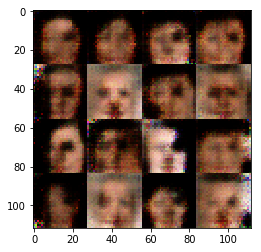

Epoch 1/1, Batch 310... Discriminator Loss: 1.9435... Generator Loss: 0.2622
Epoch 1/1, Batch 320... Discriminator Loss: 1.1505... Generator Loss: 1.0108
Epoch 1/1, Batch 330... Discriminator Loss: 1.2204... Generator Loss: 0.6953
Epoch 1/1, Batch 340... Discriminator Loss: 1.2843... Generator Loss: 0.8851
Epoch 1/1, Batch 350... Discriminator Loss: 1.6007... Generator Loss: 0.5866
Epoch 1/1, Batch 360... Discriminator Loss: 1.3138... Generator Loss: 0.5444
Epoch 1/1, Batch 370... Discriminator Loss: 1.2462... Generator Loss: 1.0947
Epoch 1/1, Batch 380... Discriminator Loss: 1.7656... Generator Loss: 2.2470
Epoch 1/1, Batch 390... Discriminator Loss: 1.1340... Generator Loss: 0.8836
Epoch 1/1, Batch 400... Discriminator Loss: 1.3176... Generator Loss: 0.7849


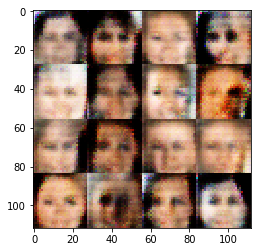

Epoch 1/1, Batch 410... Discriminator Loss: 1.2465... Generator Loss: 1.1572
Epoch 1/1, Batch 420... Discriminator Loss: 1.4537... Generator Loss: 0.4518
Epoch 1/1, Batch 430... Discriminator Loss: 1.3201... Generator Loss: 0.4877
Epoch 1/1, Batch 440... Discriminator Loss: 1.4454... Generator Loss: 0.5330
Epoch 1/1, Batch 450... Discriminator Loss: 1.3298... Generator Loss: 0.5707
Epoch 1/1, Batch 460... Discriminator Loss: 1.2647... Generator Loss: 0.9030
Epoch 1/1, Batch 470... Discriminator Loss: 1.3911... Generator Loss: 0.9937
Epoch 1/1, Batch 480... Discriminator Loss: 1.3241... Generator Loss: 0.6208
Epoch 1/1, Batch 490... Discriminator Loss: 1.4557... Generator Loss: 1.0588
Epoch 1/1, Batch 500... Discriminator Loss: 1.1443... Generator Loss: 0.9215


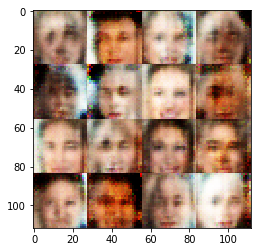

Epoch 1/1, Batch 510... Discriminator Loss: 1.2758... Generator Loss: 0.8267
Epoch 1/1, Batch 520... Discriminator Loss: 1.5036... Generator Loss: 0.4210
Epoch 1/1, Batch 530... Discriminator Loss: 1.3854... Generator Loss: 0.7935
Epoch 1/1, Batch 540... Discriminator Loss: 1.5623... Generator Loss: 0.4304
Epoch 1/1, Batch 550... Discriminator Loss: 1.4103... Generator Loss: 0.5327
Epoch 1/1, Batch 560... Discriminator Loss: 1.3703... Generator Loss: 0.5620
Epoch 1/1, Batch 570... Discriminator Loss: 1.3486... Generator Loss: 1.1276
Epoch 1/1, Batch 580... Discriminator Loss: 1.4266... Generator Loss: 0.9652
Epoch 1/1, Batch 590... Discriminator Loss: 1.4046... Generator Loss: 0.9432
Epoch 1/1, Batch 600... Discriminator Loss: 1.4184... Generator Loss: 0.6118


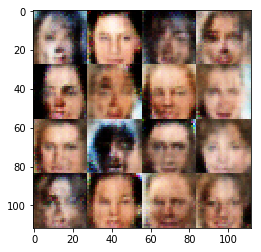

Epoch 1/1, Batch 610... Discriminator Loss: 1.5114... Generator Loss: 0.4501
Epoch 1/1, Batch 620... Discriminator Loss: 1.2159... Generator Loss: 0.8769
Epoch 1/1, Batch 630... Discriminator Loss: 1.2191... Generator Loss: 0.8029
Epoch 1/1, Batch 640... Discriminator Loss: 1.4135... Generator Loss: 0.7083
Epoch 1/1, Batch 650... Discriminator Loss: 1.3343... Generator Loss: 0.6394
Epoch 1/1, Batch 660... Discriminator Loss: 1.1623... Generator Loss: 0.8010
Epoch 1/1, Batch 670... Discriminator Loss: 1.6569... Generator Loss: 0.3129
Epoch 1/1, Batch 680... Discriminator Loss: 1.4479... Generator Loss: 0.9699
Epoch 1/1, Batch 690... Discriminator Loss: 1.4806... Generator Loss: 0.5322
Epoch 1/1, Batch 700... Discriminator Loss: 1.4286... Generator Loss: 0.7066


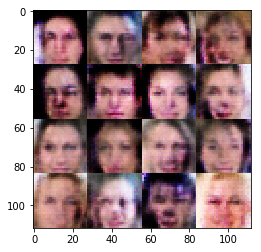

Epoch 1/1, Batch 710... Discriminator Loss: 1.5084... Generator Loss: 0.4685
Epoch 1/1, Batch 720... Discriminator Loss: 1.3298... Generator Loss: 0.5719
Epoch 1/1, Batch 730... Discriminator Loss: 1.4839... Generator Loss: 0.4718
Epoch 1/1, Batch 740... Discriminator Loss: 1.3504... Generator Loss: 0.8837
Epoch 1/1, Batch 750... Discriminator Loss: 1.3624... Generator Loss: 0.7517
Epoch 1/1, Batch 760... Discriminator Loss: 1.3851... Generator Loss: 0.6975
Epoch 1/1, Batch 770... Discriminator Loss: 1.3412... Generator Loss: 0.7347
Epoch 1/1, Batch 780... Discriminator Loss: 1.5603... Generator Loss: 0.8793
Epoch 1/1, Batch 790... Discriminator Loss: 1.4439... Generator Loss: 0.9013
Epoch 1/1, Batch 800... Discriminator Loss: 1.2704... Generator Loss: 0.7777


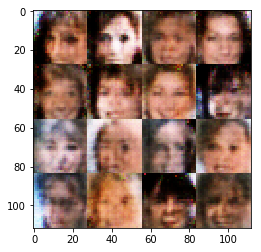

Epoch 1/1, Batch 810... Discriminator Loss: 1.3800... Generator Loss: 0.7376
Epoch 1/1, Batch 820... Discriminator Loss: 1.4096... Generator Loss: 0.6723
Epoch 1/1, Batch 830... Discriminator Loss: 1.4296... Generator Loss: 0.8342
Epoch 1/1, Batch 840... Discriminator Loss: 1.3016... Generator Loss: 0.7175
Epoch 1/1, Batch 850... Discriminator Loss: 1.2782... Generator Loss: 0.8677
Epoch 1/1, Batch 860... Discriminator Loss: 1.3647... Generator Loss: 0.6739
Epoch 1/1, Batch 870... Discriminator Loss: 1.3471... Generator Loss: 0.8642
Epoch 1/1, Batch 880... Discriminator Loss: 1.3957... Generator Loss: 0.5575
Epoch 1/1, Batch 890... Discriminator Loss: 1.7368... Generator Loss: 1.2574
Epoch 1/1, Batch 900... Discriminator Loss: 1.5009... Generator Loss: 0.6282


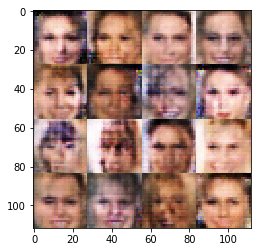

Epoch 1/1, Batch 910... Discriminator Loss: 1.3677... Generator Loss: 0.6852
Epoch 1/1, Batch 920... Discriminator Loss: 1.6121... Generator Loss: 0.5687
Epoch 1/1, Batch 930... Discriminator Loss: 1.3647... Generator Loss: 0.7624
Epoch 1/1, Batch 940... Discriminator Loss: 1.4690... Generator Loss: 0.7360
Epoch 1/1, Batch 950... Discriminator Loss: 1.3569... Generator Loss: 0.7658
Epoch 1/1, Batch 960... Discriminator Loss: 1.4962... Generator Loss: 0.6335
Epoch 1/1, Batch 970... Discriminator Loss: 1.5038... Generator Loss: 0.5383
Epoch 1/1, Batch 980... Discriminator Loss: 1.4612... Generator Loss: 0.6283
Epoch 1/1, Batch 990... Discriminator Loss: 1.3139... Generator Loss: 0.9804
Epoch 1/1, Batch 1000... Discriminator Loss: 1.3946... Generator Loss: 0.7613


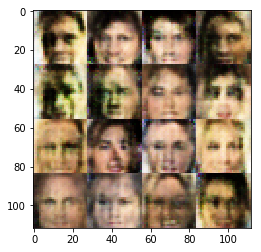

Epoch 1/1, Batch 1010... Discriminator Loss: 1.4384... Generator Loss: 0.7237
Epoch 1/1, Batch 1020... Discriminator Loss: 1.4005... Generator Loss: 0.5119
Epoch 1/1, Batch 1030... Discriminator Loss: 1.6641... Generator Loss: 0.3502
Epoch 1/1, Batch 1040... Discriminator Loss: 1.4792... Generator Loss: 0.6945
Epoch 1/1, Batch 1050... Discriminator Loss: 1.3127... Generator Loss: 0.6915
Epoch 1/1, Batch 1060... Discriminator Loss: 1.4893... Generator Loss: 0.5715
Epoch 1/1, Batch 1070... Discriminator Loss: 1.3996... Generator Loss: 0.9061
Epoch 1/1, Batch 1080... Discriminator Loss: 1.4214... Generator Loss: 0.6237
Epoch 1/1, Batch 1090... Discriminator Loss: 1.4763... Generator Loss: 0.7083
Epoch 1/1, Batch 1100... Discriminator Loss: 1.5536... Generator Loss: 0.7642


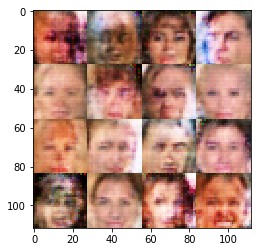

Epoch 1/1, Batch 1110... Discriminator Loss: 1.3704... Generator Loss: 0.6495
Epoch 1/1, Batch 1120... Discriminator Loss: 1.3899... Generator Loss: 0.7063
Epoch 1/1, Batch 1130... Discriminator Loss: 1.4549... Generator Loss: 0.7045
Epoch 1/1, Batch 1140... Discriminator Loss: 1.4235... Generator Loss: 0.6281
Epoch 1/1, Batch 1150... Discriminator Loss: 1.5087... Generator Loss: 0.5388
Epoch 1/1, Batch 1160... Discriminator Loss: 1.3290... Generator Loss: 0.7423
Epoch 1/1, Batch 1170... Discriminator Loss: 1.4356... Generator Loss: 0.6605
Epoch 1/1, Batch 1180... Discriminator Loss: 1.3852... Generator Loss: 0.5505
Epoch 1/1, Batch 1190... Discriminator Loss: 1.4437... Generator Loss: 0.6099
Epoch 1/1, Batch 1200... Discriminator Loss: 1.3665... Generator Loss: 0.7382


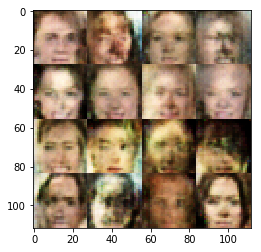

Epoch 1/1, Batch 1210... Discriminator Loss: 1.3967... Generator Loss: 0.7870
Epoch 1/1, Batch 1220... Discriminator Loss: 1.4372... Generator Loss: 0.7457
Epoch 1/1, Batch 1230... Discriminator Loss: 1.4169... Generator Loss: 0.7379
Epoch 1/1, Batch 1240... Discriminator Loss: 1.5279... Generator Loss: 0.6033
Epoch 1/1, Batch 1250... Discriminator Loss: 1.2435... Generator Loss: 0.7374
Epoch 1/1, Batch 1260... Discriminator Loss: 1.4102... Generator Loss: 0.5657
Epoch 1/1, Batch 1270... Discriminator Loss: 1.3231... Generator Loss: 0.7014
Epoch 1/1, Batch 1280... Discriminator Loss: 1.3385... Generator Loss: 0.8066
Epoch 1/1, Batch 1290... Discriminator Loss: 1.3832... Generator Loss: 0.7655
Epoch 1/1, Batch 1300... Discriminator Loss: 1.4922... Generator Loss: 0.5540


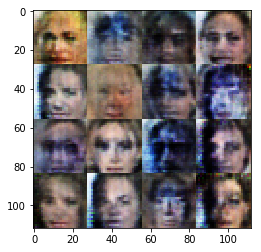

Epoch 1/1, Batch 1310... Discriminator Loss: 1.3676... Generator Loss: 0.7355
Epoch 1/1, Batch 1320... Discriminator Loss: 1.3291... Generator Loss: 0.7880
Epoch 1/1, Batch 1330... Discriminator Loss: 1.4746... Generator Loss: 0.6458
Epoch 1/1, Batch 1340... Discriminator Loss: 1.3696... Generator Loss: 0.7739
Epoch 1/1, Batch 1350... Discriminator Loss: 1.4081... Generator Loss: 0.5609
Epoch 1/1, Batch 1360... Discriminator Loss: 1.3419... Generator Loss: 0.6978
Epoch 1/1, Batch 1370... Discriminator Loss: 1.3415... Generator Loss: 0.8237
Epoch 1/1, Batch 1380... Discriminator Loss: 1.3844... Generator Loss: 0.6342
Epoch 1/1, Batch 1390... Discriminator Loss: 1.3941... Generator Loss: 0.6994
Epoch 1/1, Batch 1400... Discriminator Loss: 1.4680... Generator Loss: 0.7816


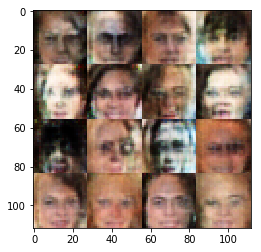

Epoch 1/1, Batch 1410... Discriminator Loss: 1.3789... Generator Loss: 0.6531
Epoch 1/1, Batch 1420... Discriminator Loss: 1.3565... Generator Loss: 0.6852
Epoch 1/1, Batch 1430... Discriminator Loss: 1.3889... Generator Loss: 0.6415
Epoch 1/1, Batch 1440... Discriminator Loss: 1.4898... Generator Loss: 0.6058
Epoch 1/1, Batch 1450... Discriminator Loss: 1.2953... Generator Loss: 0.7219
Epoch 1/1, Batch 1460... Discriminator Loss: 1.3572... Generator Loss: 0.7412
Epoch 1/1, Batch 1470... Discriminator Loss: 1.4299... Generator Loss: 0.6559
Epoch 1/1, Batch 1480... Discriminator Loss: 1.3102... Generator Loss: 0.7304
Epoch 1/1, Batch 1490... Discriminator Loss: 1.3789... Generator Loss: 0.6582
Epoch 1/1, Batch 1500... Discriminator Loss: 1.4148... Generator Loss: 0.5808


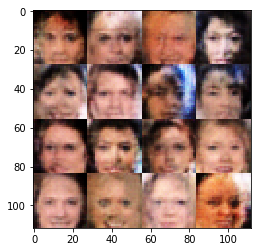

Epoch 1/1, Batch 1510... Discriminator Loss: 1.4042... Generator Loss: 0.6722
Epoch 1/1, Batch 1520... Discriminator Loss: 1.3621... Generator Loss: 0.7120
Epoch 1/1, Batch 1530... Discriminator Loss: 1.3852... Generator Loss: 0.7210
Epoch 1/1, Batch 1540... Discriminator Loss: 1.4227... Generator Loss: 0.7088
Epoch 1/1, Batch 1550... Discriminator Loss: 1.3721... Generator Loss: 0.6445
Epoch 1/1, Batch 1560... Discriminator Loss: 1.4133... Generator Loss: 0.6839
Epoch 1/1, Batch 1570... Discriminator Loss: 1.4265... Generator Loss: 0.6365
Epoch 1/1, Batch 1580... Discriminator Loss: 1.3952... Generator Loss: 0.7197
Epoch 1/1, Batch 1590... Discriminator Loss: 1.4699... Generator Loss: 0.5773
Epoch 1/1, Batch 1600... Discriminator Loss: 1.4153... Generator Loss: 0.6577


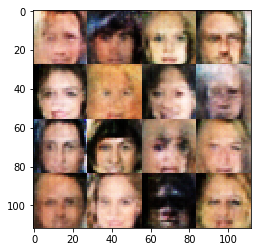

Epoch 1/1, Batch 1610... Discriminator Loss: 1.4778... Generator Loss: 0.6555
Epoch 1/1, Batch 1620... Discriminator Loss: 1.4265... Generator Loss: 0.6540
Epoch 1/1, Batch 1630... Discriminator Loss: 1.4420... Generator Loss: 0.7489
Epoch 1/1, Batch 1640... Discriminator Loss: 1.4024... Generator Loss: 0.7892
Epoch 1/1, Batch 1650... Discriminator Loss: 1.3375... Generator Loss: 0.7128
Epoch 1/1, Batch 1660... Discriminator Loss: 1.3536... Generator Loss: 0.7346
Epoch 1/1, Batch 1670... Discriminator Loss: 1.3422... Generator Loss: 0.6622
Epoch 1/1, Batch 1680... Discriminator Loss: 1.4261... Generator Loss: 0.6005
Epoch 1/1, Batch 1690... Discriminator Loss: 1.3773... Generator Loss: 0.6423
Epoch 1/1, Batch 1700... Discriminator Loss: 1.3871... Generator Loss: 0.7323


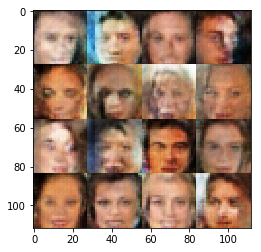

Epoch 1/1, Batch 1710... Discriminator Loss: 1.4487... Generator Loss: 0.7188
Epoch 1/1, Batch 1720... Discriminator Loss: 1.3872... Generator Loss: 0.6934
Epoch 1/1, Batch 1730... Discriminator Loss: 1.3991... Generator Loss: 0.7245
Epoch 1/1, Batch 1740... Discriminator Loss: 1.4407... Generator Loss: 0.6903
Epoch 1/1, Batch 1750... Discriminator Loss: 1.3256... Generator Loss: 0.7199
Epoch 1/1, Batch 1760... Discriminator Loss: 1.3719... Generator Loss: 0.8149
Epoch 1/1, Batch 1770... Discriminator Loss: 1.3475... Generator Loss: 0.7733
Epoch 1/1, Batch 1780... Discriminator Loss: 1.4529... Generator Loss: 0.6126
Epoch 1/1, Batch 1790... Discriminator Loss: 1.3691... Generator Loss: 0.7225
Epoch 1/1, Batch 1800... Discriminator Loss: 1.3629... Generator Loss: 0.6685


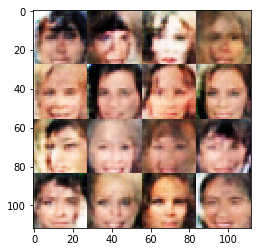

Epoch 1/1, Batch 1810... Discriminator Loss: 1.4716... Generator Loss: 0.6879
Epoch 1/1, Batch 1820... Discriminator Loss: 1.4234... Generator Loss: 0.6489
Epoch 1/1, Batch 1830... Discriminator Loss: 1.3467... Generator Loss: 0.7560
Epoch 1/1, Batch 1840... Discriminator Loss: 1.4332... Generator Loss: 0.7578
Epoch 1/1, Batch 1850... Discriminator Loss: 1.2691... Generator Loss: 0.7044
Epoch 1/1, Batch 1860... Discriminator Loss: 1.3599... Generator Loss: 0.6565
Epoch 1/1, Batch 1870... Discriminator Loss: 1.4734... Generator Loss: 0.6655
Epoch 1/1, Batch 1880... Discriminator Loss: 1.3828... Generator Loss: 0.6468
Epoch 1/1, Batch 1890... Discriminator Loss: 1.5195... Generator Loss: 0.7342
Epoch 1/1, Batch 1900... Discriminator Loss: 1.3905... Generator Loss: 0.6436


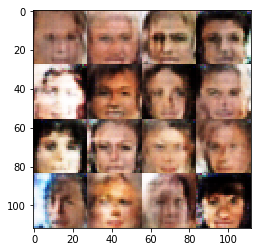

Epoch 1/1, Batch 1910... Discriminator Loss: 1.4483... Generator Loss: 0.7352
Epoch 1/1, Batch 1920... Discriminator Loss: 1.4352... Generator Loss: 0.7289
Epoch 1/1, Batch 1930... Discriminator Loss: 1.4418... Generator Loss: 0.8118
Epoch 1/1, Batch 1940... Discriminator Loss: 1.3686... Generator Loss: 0.7532
Epoch 1/1, Batch 1950... Discriminator Loss: 1.4198... Generator Loss: 0.6674
Epoch 1/1, Batch 1960... Discriminator Loss: 1.3679... Generator Loss: 0.6436
Epoch 1/1, Batch 1970... Discriminator Loss: 1.4191... Generator Loss: 0.6549
Epoch 1/1, Batch 1980... Discriminator Loss: 1.3845... Generator Loss: 0.8095
Epoch 1/1, Batch 1990... Discriminator Loss: 1.4443... Generator Loss: 0.7888
Epoch 1/1, Batch 2000... Discriminator Loss: 1.3956... Generator Loss: 0.6701


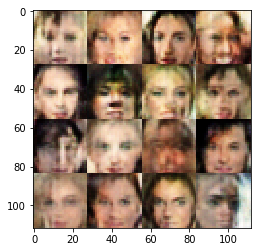

Epoch 1/1, Batch 2010... Discriminator Loss: 1.3545... Generator Loss: 0.7214
Epoch 1/1, Batch 2020... Discriminator Loss: 1.4353... Generator Loss: 0.7094
Epoch 1/1, Batch 2030... Discriminator Loss: 1.3144... Generator Loss: 0.7357
Epoch 1/1, Batch 2040... Discriminator Loss: 1.3826... Generator Loss: 0.6845
Epoch 1/1, Batch 2050... Discriminator Loss: 1.3812... Generator Loss: 0.6504
Epoch 1/1, Batch 2060... Discriminator Loss: 1.4052... Generator Loss: 0.7842
Epoch 1/1, Batch 2070... Discriminator Loss: 1.3403... Generator Loss: 0.6578
Epoch 1/1, Batch 2080... Discriminator Loss: 1.3470... Generator Loss: 0.7248
Epoch 1/1, Batch 2090... Discriminator Loss: 1.4413... Generator Loss: 0.5900
Epoch 1/1, Batch 2100... Discriminator Loss: 1.4291... Generator Loss: 0.6965


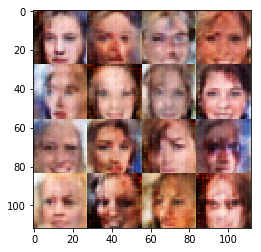

Epoch 1/1, Batch 2110... Discriminator Loss: 1.3571... Generator Loss: 0.6663
Epoch 1/1, Batch 2120... Discriminator Loss: 1.3052... Generator Loss: 0.6786
Epoch 1/1, Batch 2130... Discriminator Loss: 1.3864... Generator Loss: 0.7439
Epoch 1/1, Batch 2140... Discriminator Loss: 1.4065... Generator Loss: 0.6592
Epoch 1/1, Batch 2150... Discriminator Loss: 1.3805... Generator Loss: 0.7275
Epoch 1/1, Batch 2160... Discriminator Loss: 1.3962... Generator Loss: 0.6594
Epoch 1/1, Batch 2170... Discriminator Loss: 1.4065... Generator Loss: 0.6830
Epoch 1/1, Batch 2180... Discriminator Loss: 1.3196... Generator Loss: 0.6420
Epoch 1/1, Batch 2190... Discriminator Loss: 1.3891... Generator Loss: 0.6853
Epoch 1/1, Batch 2200... Discriminator Loss: 1.3529... Generator Loss: 0.7409


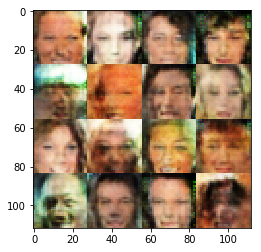

Epoch 1/1, Batch 2210... Discriminator Loss: 1.4493... Generator Loss: 0.5825
Epoch 1/1, Batch 2220... Discriminator Loss: 1.3940... Generator Loss: 0.6152
Epoch 1/1, Batch 2230... Discriminator Loss: 1.3190... Generator Loss: 0.7876
Epoch 1/1, Batch 2240... Discriminator Loss: 1.4083... Generator Loss: 0.7194
Epoch 1/1, Batch 2250... Discriminator Loss: 1.4007... Generator Loss: 0.6569
Epoch 1/1, Batch 2260... Discriminator Loss: 1.3487... Generator Loss: 0.7734
Epoch 1/1, Batch 2270... Discriminator Loss: 1.3100... Generator Loss: 0.7475
Epoch 1/1, Batch 2280... Discriminator Loss: 1.4152... Generator Loss: 0.7862
Epoch 1/1, Batch 2290... Discriminator Loss: 1.3436... Generator Loss: 0.6885
Epoch 1/1, Batch 2300... Discriminator Loss: 1.3052... Generator Loss: 0.7741


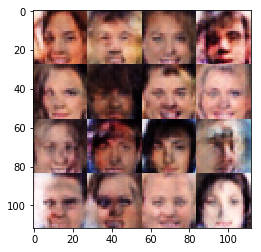

Epoch 1/1, Batch 2310... Discriminator Loss: 1.3737... Generator Loss: 0.6539
Epoch 1/1, Batch 2320... Discriminator Loss: 1.3803... Generator Loss: 0.7264
Epoch 1/1, Batch 2330... Discriminator Loss: 1.4128... Generator Loss: 0.6533
Epoch 1/1, Batch 2340... Discriminator Loss: 1.4163... Generator Loss: 0.7157
Epoch 1/1, Batch 2350... Discriminator Loss: 1.3615... Generator Loss: 0.8040
Epoch 1/1, Batch 2360... Discriminator Loss: 1.3779... Generator Loss: 0.7083
Epoch 1/1, Batch 2370... Discriminator Loss: 1.4207... Generator Loss: 0.7302
Epoch 1/1, Batch 2380... Discriminator Loss: 1.3959... Generator Loss: 0.7366
Epoch 1/1, Batch 2390... Discriminator Loss: 1.4191... Generator Loss: 0.7625
Epoch 1/1, Batch 2400... Discriminator Loss: 1.2637... Generator Loss: 0.8297


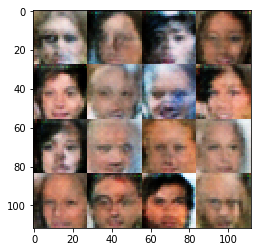

Epoch 1/1, Batch 2410... Discriminator Loss: 1.4149... Generator Loss: 0.7730
Epoch 1/1, Batch 2420... Discriminator Loss: 1.3792... Generator Loss: 0.6587
Epoch 1/1, Batch 2430... Discriminator Loss: 1.4141... Generator Loss: 0.8053
Epoch 1/1, Batch 2440... Discriminator Loss: 1.4510... Generator Loss: 0.6749
Epoch 1/1, Batch 2450... Discriminator Loss: 1.4406... Generator Loss: 0.7335
Epoch 1/1, Batch 2460... Discriminator Loss: 1.4158... Generator Loss: 0.6971
Epoch 1/1, Batch 2470... Discriminator Loss: 1.4438... Generator Loss: 0.6231
Epoch 1/1, Batch 2480... Discriminator Loss: 1.3833... Generator Loss: 0.6364
Epoch 1/1, Batch 2490... Discriminator Loss: 1.3998... Generator Loss: 0.6944
Epoch 1/1, Batch 2500... Discriminator Loss: 1.4714... Generator Loss: 0.6644


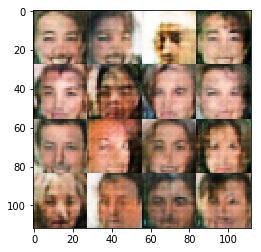

Epoch 1/1, Batch 2510... Discriminator Loss: 1.4706... Generator Loss: 0.7513
Epoch 1/1, Batch 2520... Discriminator Loss: 1.3176... Generator Loss: 0.7226
Epoch 1/1, Batch 2530... Discriminator Loss: 1.4121... Generator Loss: 0.6440
Epoch 1/1, Batch 2540... Discriminator Loss: 1.3556... Generator Loss: 0.6330
Epoch 1/1, Batch 2550... Discriminator Loss: 1.4243... Generator Loss: 0.6531
Epoch 1/1, Batch 2560... Discriminator Loss: 1.3555... Generator Loss: 0.6508
Epoch 1/1, Batch 2570... Discriminator Loss: 1.3946... Generator Loss: 0.6307
Epoch 1/1, Batch 2580... Discriminator Loss: 1.3856... Generator Loss: 0.7168
Epoch 1/1, Batch 2590... Discriminator Loss: 1.3823... Generator Loss: 0.7174
Epoch 1/1, Batch 2600... Discriminator Loss: 1.4028... Generator Loss: 0.6451


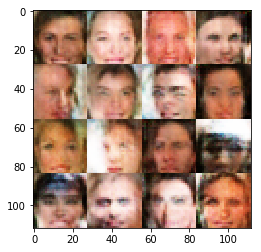

Epoch 1/1, Batch 2610... Discriminator Loss: 1.3479... Generator Loss: 0.7352
Epoch 1/1, Batch 2620... Discriminator Loss: 1.4080... Generator Loss: 0.6406
Epoch 1/1, Batch 2630... Discriminator Loss: 1.3613... Generator Loss: 0.7131
Epoch 1/1, Batch 2640... Discriminator Loss: 1.3519... Generator Loss: 0.6915
Epoch 1/1, Batch 2650... Discriminator Loss: 1.3459... Generator Loss: 0.6442
Epoch 1/1, Batch 2660... Discriminator Loss: 1.3596... Generator Loss: 0.7010
Epoch 1/1, Batch 2670... Discriminator Loss: 1.4603... Generator Loss: 0.6324
Epoch 1/1, Batch 2680... Discriminator Loss: 1.3709... Generator Loss: 0.7065
Epoch 1/1, Batch 2690... Discriminator Loss: 1.3397... Generator Loss: 0.7350
Epoch 1/1, Batch 2700... Discriminator Loss: 1.4188... Generator Loss: 0.6843


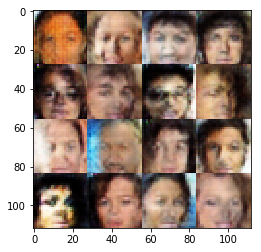

Epoch 1/1, Batch 2710... Discriminator Loss: 1.2793... Generator Loss: 0.6934
Epoch 1/1, Batch 2720... Discriminator Loss: 1.4240... Generator Loss: 0.5965
Epoch 1/1, Batch 2730... Discriminator Loss: 1.3797... Generator Loss: 0.6522
Epoch 1/1, Batch 2740... Discriminator Loss: 1.4487... Generator Loss: 0.7026
Epoch 1/1, Batch 2750... Discriminator Loss: 1.3944... Generator Loss: 0.6238
Epoch 1/1, Batch 2760... Discriminator Loss: 1.3884... Generator Loss: 0.7505
Epoch 1/1, Batch 2770... Discriminator Loss: 1.3707... Generator Loss: 0.6555
Epoch 1/1, Batch 2780... Discriminator Loss: 1.4573... Generator Loss: 0.6670
Epoch 1/1, Batch 2790... Discriminator Loss: 1.3837... Generator Loss: 0.6952
Epoch 1/1, Batch 2800... Discriminator Loss: 1.3001... Generator Loss: 0.8530


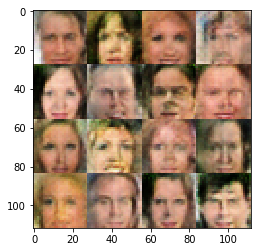

Epoch 1/1, Batch 2810... Discriminator Loss: 1.4397... Generator Loss: 0.6739
Epoch 1/1, Batch 2820... Discriminator Loss: 1.4004... Generator Loss: 0.7226
Epoch 1/1, Batch 2830... Discriminator Loss: 1.3301... Generator Loss: 0.7827
Epoch 1/1, Batch 2840... Discriminator Loss: 1.4181... Generator Loss: 0.6434
Epoch 1/1, Batch 2850... Discriminator Loss: 1.3531... Generator Loss: 0.7636
Epoch 1/1, Batch 2860... Discriminator Loss: 1.4092... Generator Loss: 0.8115
Epoch 1/1, Batch 2870... Discriminator Loss: 1.3414... Generator Loss: 0.6458
Epoch 1/1, Batch 2880... Discriminator Loss: 1.4201... Generator Loss: 0.6941
Epoch 1/1, Batch 2890... Discriminator Loss: 1.3534... Generator Loss: 0.6800
Epoch 1/1, Batch 2900... Discriminator Loss: 1.3883... Generator Loss: 0.7403


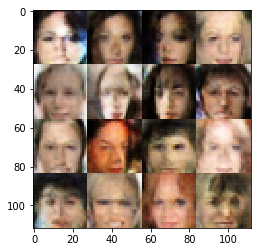

Epoch 1/1, Batch 2910... Discriminator Loss: 1.4381... Generator Loss: 0.6941
Epoch 1/1, Batch 2920... Discriminator Loss: 1.3065... Generator Loss: 0.6882
Epoch 1/1, Batch 2930... Discriminator Loss: 1.3461... Generator Loss: 0.7543
Epoch 1/1, Batch 2940... Discriminator Loss: 1.3391... Generator Loss: 0.7201
Epoch 1/1, Batch 2950... Discriminator Loss: 1.4066... Generator Loss: 0.6816
Epoch 1/1, Batch 2960... Discriminator Loss: 1.3494... Generator Loss: 0.7876
Epoch 1/1, Batch 2970... Discriminator Loss: 1.4429... Generator Loss: 0.6618
Epoch 1/1, Batch 2980... Discriminator Loss: 1.4756... Generator Loss: 0.5877
Epoch 1/1, Batch 2990... Discriminator Loss: 1.6026... Generator Loss: 0.5498
Epoch 1/1, Batch 3000... Discriminator Loss: 1.4694... Generator Loss: 0.5771


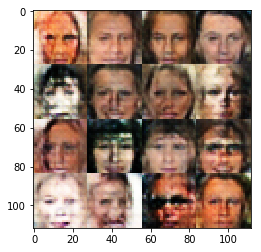

Epoch 1/1, Batch 3010... Discriminator Loss: 1.4220... Generator Loss: 0.7516
Epoch 1/1, Batch 3020... Discriminator Loss: 1.4223... Generator Loss: 0.5895
Epoch 1/1, Batch 3030... Discriminator Loss: 1.3654... Generator Loss: 0.6409
Epoch 1/1, Batch 3040... Discriminator Loss: 1.4608... Generator Loss: 0.6895
Epoch 1/1, Batch 3050... Discriminator Loss: 1.3202... Generator Loss: 0.7781
Epoch 1/1, Batch 3060... Discriminator Loss: 1.4300... Generator Loss: 0.6375
Epoch 1/1, Batch 3070... Discriminator Loss: 1.4160... Generator Loss: 0.7150
Epoch 1/1, Batch 3080... Discriminator Loss: 1.3319... Generator Loss: 0.8045
Epoch 1/1, Batch 3090... Discriminator Loss: 1.4552... Generator Loss: 0.6236
Epoch 1/1, Batch 3100... Discriminator Loss: 1.3772... Generator Loss: 0.7079


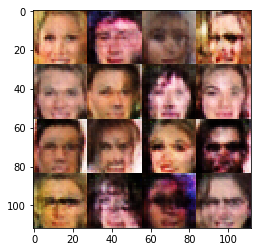

Epoch 1/1, Batch 3110... Discriminator Loss: 1.3430... Generator Loss: 0.6568
Epoch 1/1, Batch 3120... Discriminator Loss: 1.3503... Generator Loss: 0.7394
Epoch 1/1, Batch 3130... Discriminator Loss: 1.4106... Generator Loss: 0.5946
Epoch 1/1, Batch 3140... Discriminator Loss: 1.5390... Generator Loss: 0.9006
Epoch 1/1, Batch 3150... Discriminator Loss: 1.3946... Generator Loss: 0.6557
Epoch 1/1, Batch 3160... Discriminator Loss: 1.4881... Generator Loss: 0.4724


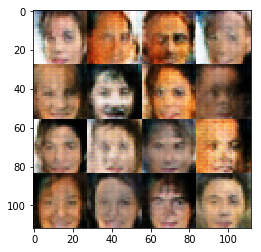

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.